In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import sys

sys.path.append('../')

from src.functions import load_dataset, cast_CCT_features

scaler = MinMaxScaler()

### Number of advisors per hour
Read the planning from the excel file

In [242]:
gs_uri = 'gs://videotron-ai-bucket/'
dataset_path = gs_uri + 'dataset/'
planning_df = pd.read_excel(dataset_path+'Planning intra-day 2020-01-01 au 2020-04-30.xlsx')
planning_df = planning_df.fillna(0.0)
planning_df

,Stauts,Date nominale,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
0,Logged in,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,2,1,1,1,1,1,1,1,1,1
1,Logged in,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,6,4,4,3,2,2,1,1,1,1
2,Logged in,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,9,7,5,3,3,2,2,1,2,2
3,Logged in,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,3,3,2,2,2,1,1,1,1,1
4,Logged in,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,3,2,2,2,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Logged in,2020-04-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,3,2,3,3,1,1,1,1,1,1
117,Logged in,2020-04-27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,...,9,8,8,8,3,2,2,1,1,1
118,Logged in,2020-04-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,10,9,10,9,3,2,2,1,1,1
119,Logged in,2020-04-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,8,8,9,8,3,2,2,1,1,1


### Display an histograms of mean number of advisors in the IT call center of calls per hour of the day

Text(0.5, 0, 'Hour')

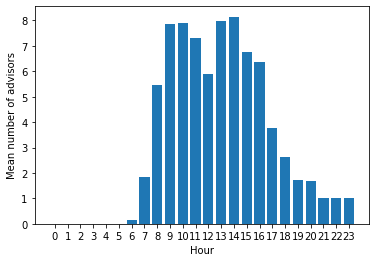

In [243]:
hours_cols = planning_df.iloc[:,2:].columns.values
x = range(0, 24)
y = planning_df[hours_cols].mean(axis=0).values

plt.bar(x, y)

plt.ylabel('Mean number of advisors')
plt.xticks(x)
plt.xlabel('Hour')

### Compute the avg number of advisors in the working hours

In [244]:
# Most calls happen in this period
working_hours_cols = ['08:00', '09:00', '10:00', '11:00', '12:00',
        '13:00', '14:00', '15:00', '16:00', '17:00']
planning_df['date'] = pd.to_datetime(planning_df['Date nominale'])
planning_df['avg_num_advisors'] = planning_df[hours_cols].mean(axis=1).round(1)
planning_df['avg_num_advisors_8_to_5'] = planning_df[working_hours_cols].mean(axis=1)
advisor_df = planning_df[['date', 'avg_num_advisors','avg_num_advisors_8_to_5']]

advisor_df

,date,avg_num_advisors,avg_num_advisors_8_to_5
0,2020-01-01,1.1,1.9
1,2020-01-02,2.4,4.7
2,2020-01-03,3.2,6.2
3,2020-01-04,1.4,2.6
4,2020-01-05,1.3,2.4
...,...,...,...
116,2020-04-26,1.5,2.9
117,2020-04-27,4.0,8.2
118,2020-04-28,4.1,8.6
119,2020-04-29,3.6,7.5


### Daily Performance of the IT call center
The average times are in seconds

In [245]:
perfo_df = pd.read_csv(dataset_path + 'performance_centre_appels_sept2017_mars2020.csv', encoding='iso-8859-1')
perfo_df.columns = ['week_day', 'date', 'total_calls', 'accept', 'accept_percent', 'abandon', 'abandon_percent',
                'SLA', 'avg_time_treat', 'avg_time_engage', 'avg_time_accept', 'avg_time_abadon', 
                'max_time_accept', 'max_time_abandon', 'accept_percent_no_attend', 'abandon_during_ring',
                'abandon_short', 'other']
perfo_df.head()

,week_day,date,total_calls,accept,accept_percent,abandon,abandon_percent,SLA,avg_time_treat,avg_time_engage,avg_time_accept,avg_time_abadon,max_time_accept,max_time_abandon,accept_percent_no_attend,abandon_during_ring,abandon_short,other
0,Vendredi,2017-09-01,448,410,0.915179,38,0.084821,0.658482,487.897561,436.109756,124.582927,137.973684,962,849,0.243902,0,1,0
1,Samedi,2017-09-02,142,133,0.936620,9,0.063380,0.802817,364.285714,333.285714,78.804511,161.111111,1441,369,0.721805,0,0,0
2,Dimanche,2017-09-03,113,106,0.938053,7,0.061947,0.867257,279.584906,259.566038,51.481132,114.714286,402,354,0.471698,0,2,0
3,Lundi,2017-09-04,205,186,0.907317,19,0.092683,0.863415,407.005376,382.005376,27.666667,231.944444,449,1021,0.774194,1,2,0
4,Mardi,2017-09-05,787,698,0.886912,89,0.113088,0.592122,417.938395,381.512894,146.882521,148.918605,683,681,0.163324,3,4,1


### Average daily abandon percentage

#### First objective: **Drop goal 10%**:
Percentage Total of abandoned calls per day. The objective is to reach an average daily percentage of abandoned calls less than or equal to **10%** of all calls Receipts


* Current average daily percentage of abandoned calls is 20% for year 2020. So we need to divide by two this metric
* Given the strong correlation between abandon percentage and average wait time, reducing average wait time will decrease abandon percentage

In [246]:
# Convert the average time from minutes to hours
perfo_df['avg_time_accept_min'] = perfo_df['avg_time_accept'] / 60.
perfo_df['avg_time_abandon_min'] = perfo_df['avg_time_abadon'] / 60.

# Set he abandon percentage
perfo_df['abandon_percentage'] = perfo_df['abandon_percent'] * 100.

# Define the start of the test period
test_df = perfo_df[perfo_df['date'] >= '2020-01-01'].copy().reset_index(drop=True)

#
mean_abandon = test_df['abandon_percentage'].mean()
print('Mean abandon percentage on the test period: %.2f%%' % mean_abandon)

Mean abandon percentage on the test period: 19.99%


### Compute the correlation between average waiting time and abandon percentage

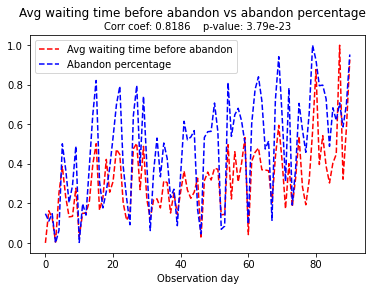

In [247]:
x  = range(test_df.shape[0])

# Scale the data
scaler.fit(test_df[['avg_time_abandon_min', 'abandon_percentage']])
y = scaler.transform(test_df[['avg_time_abandon_min', 'abandon_percentage']])
y1 = y[:, 0]
y2 = y[:, 1]

# Do a pearson correlation analysis
pearson_r , p_val = stats.pearsonr(y1, y2)
title_str = 'Corr coef: {0:.4f}    p-value: {1:.2e}'.format(pearson_r , p_val)

plt.suptitle('Avg waiting time before abandon vs abandon percentage')
plt.title(title_str, size=10)
plt.plot(x, y1, 'r--', label='Avg waiting time before abandon') 
plt.plot(x, y2, 'b--', label='Abandon percentage')
plt.xlabel('Observation day')
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


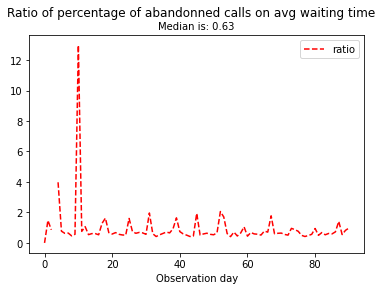

The median ratio of percentage of abandonned calls on avg waiting time is 0.63


In [248]:
meadian_ratio = np.median(y1/y2)

plt.plot(x, y1/y2, 'r--', label='ratio') 
plt.suptitle('Ratio of percentage of abandonned calls on avg waiting time')
plt.title('Median is: {0:.2f}'.format(meadian_ratio), size=10)
plt.xlabel('Observation day')
plt.legend()
plt.show()

print('The median ratio of percentage of abandonned calls on avg waiting time is {0:.2f}'.format(meadian_ratio))

### Compute the correlation between the number of calls and the waiting time
On the test period

Corr coef: 0.3767, p-value: 2.33e-04


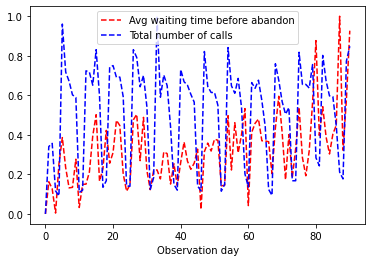

In [249]:
x  = range(test_df.shape[0])

# Scale the data
scaler.fit(test_df[['avg_time_abandon_min', 'total_calls']])
y = scaler.transform(test_df[['avg_time_abandon_min', 'total_calls']])
y1 = y[:, 0]
y2 = y[:, 1]

# Do a pearson correlation analysis
pearson_r , p_val = stats.pearsonr(y1, y2)
print('Corr coef: %.4f, p-value: %.2e' % (pearson_r , p_val))

plt.plot(x, y1, 'r--', label='Avg waiting time before abandon') 
plt.plot(x, y2, 'b--', label='Total number of calls')
plt.xlabel('Observation day')
plt.legend()
plt.show()

### Compute the correlation between the number of calls and the waiting time
On the 2 first months of the test. This correspond to a period before the COVID-19 crisis

Corr coef: 0.5513, p-value: 4.13e-06


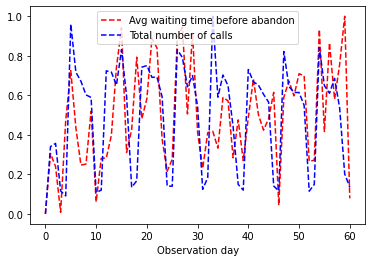

In [250]:
x  = range(test_df.loc[0:60, :].shape[0])

# Scale the data
scaler.fit(test_df.loc[0:60, ['avg_time_abandon_min', 'total_calls']])
y = scaler.transform(test_df.loc[0:60, ['avg_time_abandon_min', 'total_calls']])
y1 = y[:, 0]
y2 = y[:, 1]

# Do a pearson correlation analysis
pearson_r , p_val = stats.pearsonr(y1, y2)
print('Corr coef: %.4f, p-value: %.2e' % (pearson_r , p_val))

plt.plot(x, y1, 'r--', label='Avg waiting time before abandon') 
plt.plot(x, y2, 'b--', label='Total number of calls')
plt.xlabel('Observation day')
plt.legend()
plt.show()

### Daily wait time

#### Second objective: 
* The curent weekly waiting time is 550 hours
* The objective is to reduce the weekly waiting time to 300 hours 
* A week is from monday to sunday

* The waiting time is depends on the volume of calls (see correlation analysis above)
* **time to lose**: operational time we could save on IT call center ressources. THis means we could've let the clients wait more time to reduce call center capacity and therefore reduce the opertional cost of the IT call center
* **time to gain**: hours worked by the Videotron's employee. This means we should answer quicker by increasing capacity when required. The Videotron's employee will wait less time when they call the IT center and thereore will be more productive


#### Assumption: We assume that if given the perfectly accurate prediction of number of calls, the call center management will be able to allocate exact number of advisors to keep desire average wait time

In [251]:
test_df.columns.values

array(['week_day', 'date', 'total_calls', 'accept', 'accept_percent',
       'abandon', 'abandon_percent', 'SLA', 'avg_time_treat',
       'avg_time_engage', 'avg_time_accept', 'avg_time_abadon',
       'max_time_accept', 'max_time_abandon', 'accept_percent_no_attend',
       'abandon_during_ring', 'abandon_short', 'other',
       'avg_time_accept_min', 'avg_time_abandon_min',
       'abandon_percentage'], dtype=object)

In [252]:
test_df['avg_time_abandon_min']

0      0.500000
1      4.936275
2      3.978030
3      0.616667
4      7.370833
        ...    
86    12.725094
87    27.763889
88     9.288889
89    16.305106
90    25.770735
Name: avg_time_abandon_min, Length: 91, dtype: float64

In [253]:
test_df

,week_day,date,total_calls,accept,accept_percent,abandon,abandon_percent,SLA,avg_time_treat,avg_time_engage,...,avg_time_abadon,max_time_accept,max_time_abandon,accept_percent_no_attend,abandon_during_ring,abandon_short,other,avg_time_accept_min,avg_time_abandon_min,abandon_percentage
0,Mercredi,2020-01-01,27,25,0.925926,2,0.074074,0.814815,384.880000,312.280000,...,30.000000,750,36,0.640000,0,0,0,1.324000,0.500000,7.407407
1,Jeudi,2020-01-02,285,268,0.940351,17,0.059649,0.603509,366.619403,310.440298,...,296.176471,1526,1016,0.511194,0,1,0,3.905286,4.936275,5.964912
2,Vendredi,2020-01-03,297,275,0.925926,22,0.074074,0.663300,458.356364,412.469091,...,238.681818,1417,1029,0.545455,0,1,0,3.881394,3.978030,7.407407
3,Samedi,2020-01-04,115,113,0.982609,2,0.017391,0.808696,363.079646,321.415929,...,37.000000,1216,68,0.690265,0,1,1,1.876401,0.616667,1.739130
4,Dimanche,2020-01-05,96,92,0.958333,4,0.041667,0.718750,436.108696,381.576087,...,442.250000,1357,1236,0.565217,0,0,0,2.134420,7.370833,4.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Vendredi,2020-03-27,365,272,0.745205,93,0.254795,0.145205,610.566176,552.172794,...,763.505618,3494,2782,0.058824,4,3,2,21.063664,12.725094,25.479452
87,Samedi,2020-03-28,187,133,0.711230,54,0.288770,0.224599,501.105263,444.451128,...,1665.833333,8123,6409,0.172932,0,2,0,32.897995,27.763889,28.877005
88,Dimanche,2020-03-29,161,122,0.757764,39,0.242236,0.279503,437.696721,388.016393,...,557.333333,3916,2522,0.270492,0,1,0,15.845765,9.288889,24.223602
89,Lundi,2020-03-30,612,437,0.714052,175,0.285948,0.194444,557.473684,501.304348,...,978.306358,4221,3451,0.068650,2,1,7,28.223722,16.305106,28.594771


### Weekly wait time
Compute the weekly wait time in hours during the test period.

Reminder: the average times are in second in the dataframe

In [254]:
test_df['total_time_accept']  = (test_df['avg_time_accept'] * test_df['accept']) / (60 * 60)
test_df['total_time_abandon'] = (test_df['avg_time_abadon'] * test_df['abandon']) /  (60 * 60)
test_df['total_time'] = test_df['total_time_accept'] + test_df['total_time_abandon']
test_df['total_time_desire']  = 300/7 # The desired time is the weekly objective divided by 7 (7 days in a week)

test_df['date'] = pd.to_datetime(test_df['date'])

In [255]:
out_df = test_df[['date', 'total_calls', 'total_time_accept', 'total_time_abandon', 'total_time', 'total_time_desire']]
out_df = test_df.resample('W-Mon', on='date')\
          .agg({'total_calls': np.sum,
                'total_time_accept' : np.sum, 
                'total_time_abandon' : np.sum,
                'total_time': np.sum,
                'total_time_desire' : np.sum}).reset_index()\
          .sort_values(by='date')

out_df['mean_waiting_time (minutes)'] = (out_df['total_time']/out_df['total_calls'])*60

# Compute the desired waiting time per call every week in order to achieve the 300 hours of waiting time per week
out_df['mean_waiting_time_desired (minutes)'] = (out_df['total_time_desire']/out_df['total_calls'])*60
out_df['week'] = out_df['date'].apply(lambda x: x.strftime('%U'))
out_df['year'] = out_df['date'].apply(lambda x: x.strftime('%Y'))

# #
# print('Total desired weekly waiting time: %d hours' % out_df['total_time_desire'].mean())
out_df

,date,total_calls,total_time_accept,total_time_abandon,total_time,total_time_desire,mean_waiting_time (minutes),mean_waiting_time_desired (minutes),week,year
0,2020-01-06,1574,197.718889,32.423889,230.142778,257.142857,8.772914,9.802142,01,2020
1,2020-01-13,2863,269.571667,35.200678,304.772345,300.000000,6.387126,6.287111,02,2020
2,2020-01-20,3096,553.461111,109.644346,663.105457,300.000000,12.850881,5.813953,03,2020
3,2020-01-27,3095,636.373333,140.391343,776.764676,300.000000,15.058443,5.815832,04,2020
4,2020-02-03,3206,587.651667,127.817778,715.469444,300.000000,13.389946,5.614473,05,2020
5,2020-02-10,2750,350.370556,54.363126,404.733681,300.000000,8.830553,6.545455,06,2020
6,2020-02-17,2891,476.483056,87.031916,563.514971,300.000000,11.695226,6.226219,07,2020
7,2020-02-24,2860,543.780556,133.907082,677.687638,300.000000,14.217223,6.293706,08,2020
8,2020-03-02,2826,525.653889,120.237563,645.891452,300.000000,13.713194,6.369427,09,2020
9,2020-03-09,2690,591.743056,154.143950,745.887006,300.000000,16.636885,6.691450,10,2020


### Compute the mean desired waiting time by call every week of the test period

In [256]:
current_waiting_time = out_df['mean_waiting_time (minutes)'].mean()
WAITING_TIME_GOAL = out_df['mean_waiting_time_desired (minutes)'].mean()

print('During the test period, the current mean waiting time for 1 call is: %.1f minutes' % current_waiting_time)
print('During the test period, the desired mean waiting time for 1 call is: %.1f minutes' % WAITING_TIME_GOAL)

During the test period, the current mean waiting time for 1 call is: 14.9 minutes
During the test period, the desired mean waiting time for 1 call is: 6.3 minutes


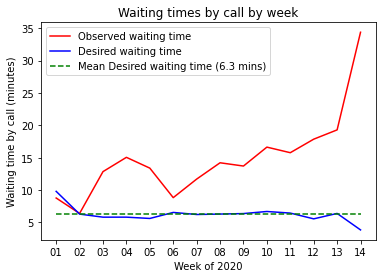

In [257]:
y1 = out_df['mean_waiting_time (minutes)'].values
y2 = out_df['mean_waiting_time_desired (minutes)'].values

x = out_df['week'].values
y3 = WAITING_TIME_GOAL*np.ones(len(x))

plt.plot(x, y1, 'r', label='Observed waiting time')
plt.plot(x, y2, 'b', label='Desired waiting time')
plt.plot(x, y3, 'g--', label=f'Mean Desired waiting time ({WAITING_TIME_GOAL:.2} mins)')

plt.ylabel('Waiting time by call (minutes)')
plt.xlabel('Week of ' + str(out_df.loc[0,'year']))
plt.title('Waiting times by call by week')
plt.legend()

plt.show()

### Compute the mean desired abandon percentage based on the desired waiting time for one call

In [258]:
avg_abandon_percent_desired = test_df[test_df['avg_time_abandon_min'] <= WAITING_TIME_GOAL][['abandon_percentage']].mean()
print('Average percentage of abandonned calls desired: %.2f%%' % avg_abandon_percent_desired)

Average percentage of abandonned calls desired: 8.39%


### Compute the possible gain on the accept waiting time and the abandon waiting time
* For the calls accepted, if we can answer before the WAITING TIME GOAL, the time gain can be translate to more productivity for the Videotron's employee
* For the calls with an abandon, if we can answer before the WAITING TIME GOAL, less people will abandon, the waiting time will decrease, the videotron's employee will not try a second time to call and can work instead. The gain is also in productivity

We should focus on the gains on th waitings times because the cost of a videotron's employee waiting is much higher that the cost of an operator in the IT call center

In [259]:
test_df['accept_time_gains']  = (test_df['avg_time_accept_min']  - WAITING_TIME_GOAL) * test_df['accept']  / 60
test_df['abandon_time_gains'] = (test_df['avg_time_abandon_min'] - WAITING_TIME_GOAL) * test_df['abandon'] / 60

accept_wt_loss = test_df.loc[test_df['accept_time_gains'] <  0, 'accept_time_gains'].sum()
accept_wt_gain = test_df.loc[test_df['accept_time_gains'] >= 0, 'accept_time_gains'].sum()
abandon_wt_loss = test_df.loc[test_df['abandon_time_gains'] <  0, 'abandon_time_gains'].sum()
abandon_wt_gain = test_df.loc[test_df['abandon_time_gains'] >= 0, 'abandon_time_gains'].sum()

print("Accept time to lose", accept_wt_loss, 'hours')
print("Accept time to gain", accept_wt_gain, 'hours')
#
print("Abandon time to lose", abandon_wt_loss, 'hours')
print("Abandon time to gain", abandon_wt_gain, 'hours')

Accept time to lose -184.9400347096758 hours
Accept time to gain 4247.596788888869 hours
Abandon time to lose -15.46881148654444 hours
Abandon time to gain 767.8229936635731 hours


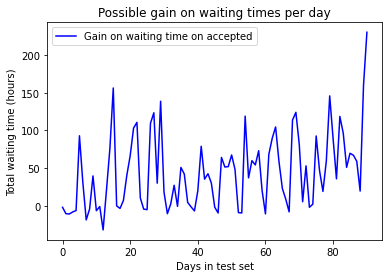

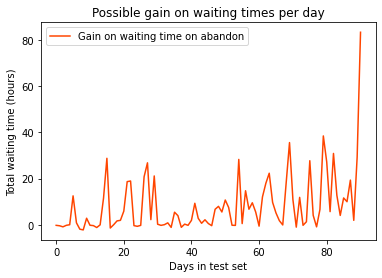

In [260]:
y1 = test_df['accept_time_gains'].values
y2 = test_df['abandon_time_gains'].values

x = test_df.index

plt.plot(x, y1, 'b', label='Gain on waiting time on accepted')
plt.ylabel('Total waiting time (hours)')
plt.xlabel('Days in test set')
plt.title('Possible gain on waiting times per day')
plt.legend()

plt.show()


plt.plot(x, y2, 'orangered', label='Gain on waiting time on abandon')
plt.ylabel('Total waiting time (hours)')
plt.xlabel('Days in test set')
plt.title('Possible gain on waiting times per day')
plt.legend()

plt.show()

### Join with number of advisors

- Can get the number of calls per hour to join with number of advisors per hour for next step


### Temporary Conclusion

- if ratio between average number of call volume per hour and average number of advisors per hours is < 5, then average wait time should be within 7 minutes desired wait time

### Average ratio between average number of calls and average number of advisors per hour that result in wait time less than optimal wait time

Get the number of calls per hour

In [261]:
CCT_df, perfo_df = load_dataset(dataset_path)
CCT_df = CCT_df.loc[~CCT_df['Submitter'].str.contains('SYSTEM')]
CCT_df = cast_CCT_features(CCT_df)

Dataframe memory usage: 106.62 MB
Converting Submit_Date
Converting closed_date
Dataframe memory usage: 83.98 MB


In [262]:
rename_dict = {'status': 'ticket count',
               'Submit_Date_with_hour': 'datetime'}

ticket_stats_df = CCT_df.groupby('Submit_Date_with_hour')['status'].count().reset_index()
ticket_stats_df.rename(columns=rename_dict, inplace=True)
ticket_stats_df['datetime'] = pd.to_datetime(ticket_stats_df['datetime'])
# ticket_stats_df['datetime_int'] = ticket_stats_df['datetime'].astype('int')

# ticket_stats_df['date'] = ticket_stats_df['datetime'].apply(lambda x: x.date())
# ticket_stats_df['hour'] = ticket_stats_df['datetime'].apply(lambda x: x.hour)

ticket_stats_df

,datetime,ticket count
0,2017-10-01 07:00:00,5
1,2017-10-01 08:00:00,21
2,2017-10-01 09:00:00,9
3,2017-10-01 10:00:00,12
4,2017-10-01 11:00:00,10
...,...,...
14965,2020-04-01 07:00:00,11
14966,2020-04-01 08:00:00,21
14967,2020-04-01 09:00:00,35
14968,2020-04-01 10:00:00,51


### Add the number of advisors along the number of call per hour

In [263]:
planning_df['Date nominale'] = pd.to_datetime(planning_df['Date nominale'])

datetime_list = []
nb_advisor_list = []

for i, dt in enumerate(planning_df['Date nominale']):
    for col in planning_df[hours_cols]:
        nb_advisors = planning_df.loc[planning_df['Date nominale'] == dt, col][i]
        datetime_list.append(f'{dt.date()} {col}')
        nb_advisor_list.append(int(nb_advisors))

nb_advisors_df = pd.DataFrame.from_dict({'datetime': datetime_list,
                                         'nb advisors': nb_advisor_list})
nb_advisors_df['datetime'] = pd.to_datetime(nb_advisors_df['datetime'])

nb_advisors_df['date'] = nb_advisors_df['datetime'].apply(lambda x: x.date())
nb_advisors_df['date'] = pd.to_datetime(nb_advisors_df['date'])
nb_advisors_df['hour'] = nb_advisors_df['datetime'].apply(lambda x: x.hour)

# Merge the number of tickets per hours with the number of advisors per hour
nb_advisors_df = nb_advisors_df.merge(ticket_stats_df, how='left', on='datetime')
nb_advisors_df['ticket count'] = nb_advisors_df['ticket count'].fillna(0)

# Compute the ratio number of tickets by advisors
nb_advisors_df['ticket count per advisor'] = (nb_advisors_df['ticket count']/nb_advisors_df['nb advisors']).fillna(0)
nb_advisors_df['ticket count per advisor'] = nb_advisors_df['ticket count per advisor'].replace([np.inf, -np.inf], np.nan)
nb_advisors_df

,datetime,nb advisors,date,hour,ticket count,ticket count per advisor
0,2020-01-01 00:00:00,0,2020-01-01,0,0.0,0.0
1,2020-01-01 01:00:00,0,2020-01-01,1,0.0,0.0
2,2020-01-01 02:00:00,0,2020-01-01,2,0.0,0.0
3,2020-01-01 03:00:00,0,2020-01-01,3,0.0,0.0
4,2020-01-01 04:00:00,0,2020-01-01,4,0.0,0.0
...,...,...,...,...,...,...
2899,2020-04-30 19:00:00,2,2020-04-30,19,0.0,0.0
2900,2020-04-30 20:00:00,2,2020-04-30,20,0.0,0.0
2901,2020-04-30 21:00:00,1,2020-04-30,21,0.0,0.0
2902,2020-04-30 22:00:00,1,2020-04-30,22,0.0,0.0


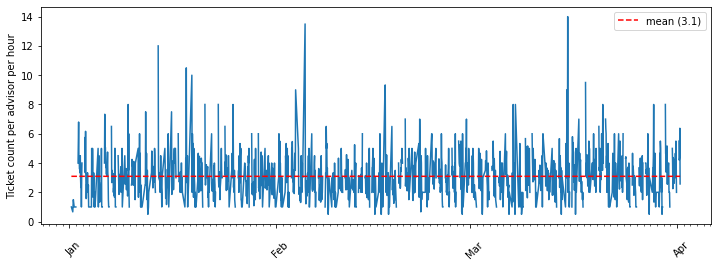

In [196]:
import matplotlib

cond = (nb_advisors_df['ticket count per advisor'] != 0)

fig, ax = plt.subplots(figsize=(12,4))

y = nb_advisors_df.loc[cond, 'ticket count per advisor'].values
x = nb_advisors_df.loc[cond, ['datetime']]
mean = nb_advisors_df.loc[cond, 'ticket count per advisor'].mean()

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(list(range(1,13))))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(list(range(1,90))))

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%b"))
# ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%d"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

plt.plot(x, y)
plt.plot(x, mean*np.ones(len(y)), 'r--', label=f'mean ({mean:.2})')
plt.ylabel('Ticket count per advisor per hour')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

In [239]:
nb_advisors_df.describe()

,nb advisors,hour,ticket count,ticket count per advisor
count,2904.000000,2904.000000,2904.000000,2853.000000
mean,3.271350,11.500000,7.384298,1.529103
std,3.800945,6.923379,11.216701,1.868160
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.750000,0.000000,0.000000
50%,2.000000,11.500000,1.000000,0.000000
75%,5.000000,17.250000,11.000000,3.000000
max,16.000000,23.000000,82.000000,14.000000


In [240]:
cond = ((nb_advisors_df['hour'] >= 8) & (nb_advisors_df['hour'] <= 17))
nb_advisors_df.loc[cond].describe()

,nb advisors,hour,ticket count,ticket count per advisor
count,1210.000000,1210.000000,1210.000000,1210.000000
mean,6.745455,12.500000,15.466942,2.389696
std,3.576136,2.873469,13.210930,1.752984
min,1.000000,8.000000,0.000000,0.000000
25%,3.000000,10.000000,0.250000,0.125000
50%,7.000000,12.500000,14.000000,2.630682
75%,9.000000,15.000000,26.000000,3.500000
max,16.000000,17.000000,82.000000,14.000000


In [227]:
cond = ((nb_advisors_df['hour'] >= 8) & (nb_advisors_df['hour'] <= 17))

agg_df = nb_advisors_df.loc[cond].groupby('date').mean()
agg_df

,nb advisors,hour,ticket count,ticket count per advisor
date,,,,
2020-01-01,1.9,12.5,0.6,0.316667
2020-01-02,4.7,12.5,19.7,4.131667
2020-01-03,6.2,12.5,18.4,3.167817
2020-01-04,2.6,12.5,8.3,3.200000
2020-01-05,2.4,12.5,5.5,2.300000
...,...,...,...,...
2020-04-26,2.9,12.5,0.0,0.000000
2020-04-27,8.2,12.5,0.0,0.000000
2020-04-28,8.6,12.5,0.0,0.000000


In [233]:
nb_advisors_df.loc[cond].groupby('hour').mean()

,nb advisors,ticket count,ticket count per advisor
hour,,,
8,5.471074,15.578512,2.605906
9,7.851240,18.644628,2.400303
10,7.892562,18.760331,2.537223
11,7.305785,17.611570,2.640408
12,5.892562,14.702479,2.788639
13,7.983471,16.834711,2.133855
14,8.148760,15.867769,1.945488
15,6.776860,14.966942,2.335025
16,6.347107,13.041322,2.103089


In [238]:
test_df = test_df[['date', 'total_calls', 'accept_percent', 'abandon_percent', 'avg_time_accept_min', 'avg_time_abandon_min']]
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.merge(advisor_df, on='date', how='inner')

# Divide by 10 => approximation for the 10 hours of working hours
test_df['ratio_call_advisor'] = (test_df['total_calls'] / 10) / test_df['avg_num_advisors']

# Merge Renan's ratio call advisor
test_df = test_df.merge(nb_advisors_df[['date','ticket count per advisor']], on='date', how='inner')

# Printing the average ratio between number of calls and number of advisors per hour that will result in waiting that is less than the disired wainting time
print(test_df[(test_df['avg_time_accept_min'] < WAITING_TIME_GOAL) & (test_df['avg_time_abandon_min'] < WAITING_TIME_GOAL)]['ratio_call_advisor'].mean())
print(test_df[(test_df['avg_time_accept_min'] < WAITING_TIME_GOAL) & (test_df['avg_time_abandon_min'] < WAITING_TIME_GOAL)]['ticket count per advisor'].mean())

9.129644732037503
1.7161138380916172


In [225]:
test_df['ratio_call_advisor'].describe()

count    2184.000000
mean       12.158160
std         2.945387
min         2.454545
25%        10.230769
50%        11.811321
75%        13.848485
max        19.966667
Name: ratio_call_advisor, dtype: float64

### Average ratio between average number of calls and average number of advisors per hour that result in wait time more than the optimal wait time

In [25]:
test_df[(test_df['avg_time_accept_min'] > WAITING_TIME_GOAL) & (test_df['avg_time_abandon_min'] > WAITING_TIME_GOAL)]['ratio_call_advisor'].mean()

13.424157419478098

### ROI with Prediction

In [26]:
def cast_CCT_features(df):
    dates_list = ['Submit_Date','Reported_Date','Required_Resolution_DateTime','Responded_Date','Last_Resolved_Date','closed_date']
    for col in dates_list:
        df[col] = pd.to_datetime(df[col].fillna('1900-01-01 00:00:00.000'))
        df[col + '_day'] = df[col].apply(lambda x: x.strftime('%Y-%m-%d')) # To group by day
        df[col + '_with_hour'] =df[col].apply(lambda x: x.strftime('%Y-%m-%d %H:00')) # To group by day
    return df

In [27]:
result_path = gs_uri + 'results/'

preds = pd.read_csv(result_path + 'ticket_count_prediction_202005062015.csv')
preds['date'] = pd.to_datetime(preds['date'])
#
perf = pd.read_csv(dataset_path + 'performance_centre_appels_sept2017_mars2020.csv', encoding='iso-8859-1')
perf.columns = ['week_day', 'date', 'total_calls', 'accept', 'accept_percent', 'abandon', 'abandon_percent',
                'SLA', 'avg_time_treat', 'avg_time_engage', 'avg_time_accept', 'avg_time_abadon', 
                'max_time_accept', 'max_time_abandon', 'accept_percent_no_attend', 'abandon_during_ring',
                'abandon_short', 'other']
perf['date'] = pd.to_datetime(perf['date'])
perf = perf[['date', 'total_calls', 'avg_time_accept', 'avg_time_abadon']]
#
inci = pd.read_csv(dataset_path + 'IncidentsCTT20170930_2.csv', encoding="ISO-8859-1", low_memory=False)
inci = inci.loc[~inci['Submitter'].str.contains('SYSTEM')]
inci = cast_CCT_features(inci)
groupby = inci.groupby('Submit_Date_day')
agg_df = pd.DataFrame(groupby['status'].count().reset_index().values, columns=['Submit_Date_day', 'Ticket cnt'])
agg_df['total_real_calls'] = agg_df['Ticket cnt'].astype(int)
agg_df['date'] = pd.to_datetime(agg_df['Submit_Date_day'])
agg_df = agg_df[['date', 'total_real_calls']]

In [28]:
final = preds[['date', 'ticket cnt pred']]\
                .merge(perf[['date', 'total_calls', 'avg_time_accept', 'avg_time_abadon']], 
                       on='date', how='left')\
                .merge(agg_df, on='date', how='left')
final.head()

,date,ticket cnt pred,total_calls,avg_time_accept,avg_time_abadon,total_real_calls
0,2020-01-01,102.35755,27.0,79.440000,30.000000,10
1,2020-01-02,190.30754,285.0,234.317164,296.176471,221
2,2020-01-03,186.17322,297.0,232.883636,238.681818,210
3,2020-01-04,125.01209,115.0,112.584071,37.000000,90
4,2020-01-05,120.05078,96.0,128.065217,442.250000,71


### Optimal case with perfect prediction

In [29]:
final['accept_time_gains']  = (final['avg_time_accept']/60.  - 7.) * final['total_real_calls']  / 60
#
print("accept time to lose", final.loc[final['accept_time_gains'] < 0, 'accept_time_gains'].sum(), 'hours')
print("accept time to gain", final.loc[final['accept_time_gains'] > 0, 'accept_time_gains'].sum(), 'hours')

accept time to lose -187.0101893750222 hours
accept time to gain 2918.3538171031664 hours


### With prediction

- Assume that the difference between predicted and total calls have a direct linear impact on the average wait time
- The result suggests that the prediction tend to over-predict, which benefits time to gain, and at the same time increase time to lose

In [30]:
final['avg_time_pred'] = (final['total_real_calls'] / final['ticket cnt pred']) * 7.
#
final['pred_time_gains']  = (final['avg_time_accept']/60. - final['avg_time_pred']) * final['total_real_calls'] /60.

cost_IT_call_center = int(final.loc[final['pred_time_gains'] < 0, 'pred_time_gains'].sum())
cost_WT_Videotron_employee = int(final.loc[final['pred_time_gains'] > 0, 'pred_time_gains'].sum())


print("pred time to lose (3 months): %d hours" % cost_IT_call_center)
print("pred time to gain (3 months): %d hours" % cost_WT_Videotron_employee)

pred time to lose (3 months): -199 hours
pred time to gain (3 months): 2930 hours


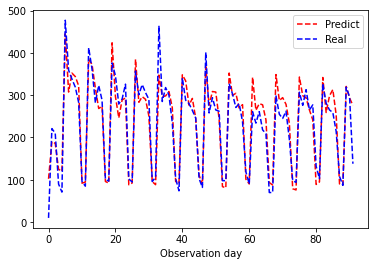

In [31]:
plt.plot(range(final.shape[0]), final['ticket cnt pred'], 'r--', label='Predict') 
plt.plot(range(final.shape[0]), final['total_real_calls'], 'b--', label='Real')
plt.xlabel('Observation day')
plt.legend()
plt.show()

### Compute the annualize ROI from the 3 months of test
Multiply by 4 the results
* Hourly rate for the employee in the IT call center: 50$ per hour

* Hourly rate for the Videotron employee when they call the IT center: 110$ per hour

In [32]:
print("Cost to lose", cost_IT_call_center * 50 * 4)
print("Cost to gain", cost_WT_Videotron_employee * 110 * 4)

Cost to lose -39800
Cost to gain 1289200


In [33]:
rate_1 = 50
rate_2 = 110

cost_IT_call_center_annualize = -1*cost_IT_call_center*4
cost_WT_Videotron_employee_annualize = cost_WT_Videotron_employee*4

print('Number of hours saved in the IT call center every year: %d' % cost_IT_call_center_annualize)
print('Number of hours of waiting time saved for the Videotron\'s employee: %d' % cost_WT_Videotron_employee_annualize)

print('Cost saved in the IT call center every year: %d$' % (cost_IT_call_center_annualize*rate_1))
print('Cost on waiting time saved for the Videotron\'s employee: {:9,.0f}$\n'.format(cost_WT_Videotron_employee_annualize*rate_2))


total_ROI = cost_IT_call_center_annualize*rate_1+cost_WT_Videotron_employee_annualize*rate_2
print(56*'*')
print('Total potential ROI of the project on 1 year: {:9,.0f}$'.format(total_ROI))
print(56*'*')

Number of hours saved in the IT call center every year: 796
Number of hours of waiting time saved for the Videotron's employee: 11720
Cost saved in the IT call center every year: 39800$
Cost on waiting time saved for the Videotron's employee: 1,289,200$

********************************************************
Total potential ROI of the project on 1 year: 1,329,000$
********************************************************
